# **Analisis de AirBnb en Medellín Colombia**

El presente jupyter notebook contiene la tercera y última fase de un proceso de exploración, extracción, transformación y análisis de datos sobre la oferta de alojamiento presente en la plataforma AirBnb en Medellín colombia.

El proyecto contó con las siguientes fases:
1. Extracción de Ids de habitaciones disponibles mediante web scrapping
2. Extracción de información relevante sobre las habitaciones mediante web scrapping
3. Procesamiento y Análisis de datos

En la primera fase del ejercicio se recolectaron 9106 IDs únicos, los cuáles sirvieron para extraer la información requerida. Ya veremos acontinuación a cuántos de estos se logró ingresar para extraer información correcta. 

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import re
from MunicipiosCOL import Municipios

## **Preprocesamiento**

Se revisará el contenido del archivo final, el tipo de datos recolectados, cantidad de información por categoría alcanzada e implementar transformaciones necesarias

In [2]:
#Abrir el archivo, y obtener información al respecto de su contenido
df_rooms = pd.read_csv('all_data_rooms.csv')
df_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8792 entries, 0 to 8791
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8792 non-null   int64  
 1   title              8192 non-null   object 
 2   price              8192 non-null   float64
 3   description        8192 non-null   object 
 4   long               8192 non-null   float64
 5   latitude           8192 non-null   float64
 6   review_airbnb      8192 non-null   float64
 7   calification_rate  6031 non-null   float64
 8   created_at         7330 non-null   object 
 9   verified           7099 non-null   object 
 10  host_review        6869 non-null   float64
 11  created_at_1       8117 non-null   object 
 12  cameras_on_site    8192 non-null   object 
 13  rooms              8192 non-null   float64
dtypes: float64(7), int64(1), object(6)
memory usage: 961.8+ KB


In [3]:
#Obtener data de muestra para tener un campo visual de su estructura
df_rooms.head()

id                                              title  \
0  1011761919469637760                    Hermoso apartamento las  palmas   
1   957959124861517056                        PVT APT  3BD  - Lleras Park   
2   705259118691125248  Amplia y acogedora casa de habitación privada ...   
3              7840662               POBLADO NEAR PARQUE LLERAS APARTMENT   
4   705231926741978496         Dormitorio privado completamente amueblado   

      price                                    description       long  \
0  640000.0  Vivienda rentada entero en Medellín, Colombia -75.557983   
1  791679.0  Vivienda rentada entero en Medellín, Colombia -75.569918   
2  676886.0               Habitación en Medellín, Colombia -75.566890   
3  712512.0  Vivienda rentada entero en Medellín, Colombia -75.564820   
4  676886.0               Habitación en Medellín, Colombia -75.565954   

   latitude  review_airbnb  calification_rate created_at verified  \
0  6.215317            0.0                NaN    08/2023     True   
1  6.210337            0.0                NaN    08/2023     True   
2  6.207200            0.0                NaN        NaN      NaN   
3  6.207240           65.0               4.86    08/2015      NaN   
4  6.208037            0.0                NaN        NaN      NaN   

   host_review created_at_1 cameras_on_site  rooms  
0          NaN        09/23            True    2.0  
1          NaN        09/23            True    2.0  
2          NaN        02/22           False    1.0  
3         65.0        02/16           False    3.0  
4          NaN        02/22           False    1.0

Hacer conversiones de datos si se requieren

En este caso, se cuenta con 2 campos tipo fecha que se están presentando como Mes-Año, por lo cual se hace necesario implementar la transformación requerida para facilidad de análisis.

In [4]:
# Definir una función para convertir mes/año a periodo, dado que uno de los campos posee un formato que no aceptable 
# con pandas directamente
def convertir_a_periodo(fecha_str):
    try:
        # Extraer el mes y el año como cadenas
        mes, año_str = fecha_str.split('/')
        
        # Obtener el año como entero
        año = int(año_str)
        
        # Ajustar los dos dígitos del año si es necesario
        if año < 100:
            if año >= 0 and año <= 24:
                año += 2000
            else:
                año += 1900
        
        # Crear un objeto periodo
        periodo = pd.Period(year=año, month=int(mes), freq='M')
        return periodo
    except (ValueError, AttributeError):
        # Manejar el caso en que la conversión falle
        return pd.NaT

# Aplicar la función a la columna 'created_at_1'
df_rooms['created_at_1'] = df_rooms['created_at_1'].apply(convertir_a_periodo)

# Aplicar conversión al otro campo fecha, en este caso no es necesario implementar la función definida
df_rooms['created_at'] = pd.to_datetime(df_rooms['created_at'], format = '%m/%Y', errors= 'coerce').dt.to_period('M')

#Presentar muestra con el cambio de tipado establecido
df_rooms.head(10)


id                                              title  \
0  1011761919469637760                    Hermoso apartamento las  palmas   
1   957959124861517056                        PVT APT  3BD  - Lleras Park   
2   705259118691125248  Amplia y acogedora casa de habitación privada ...   
3              7840662               POBLADO NEAR PARQUE LLERAS APARTMENT   
4   705231926741978496         Dormitorio privado completamente amueblado   
5   705238414467597824  Increíble dormitorio privado con una ubicación...   
6   983635104701522560                Penthouse Luxury Duplex Con Jacuzzi   
7   940756738873697792                  Casa bohemia con jacuzzi y azotea   
8  1044163892876461952  Apartamento Morph 802-Serene en Poblado con ba...   
9  1015401669235102208  Poblado Ultra Luxury 2Br+Jacuzzi privado con v...   

      price                                    description       long  \
0  640000.0  Vivienda rentada entero en Medellín, Colombia -75.557983   
1  791679.0  Vivienda rentada entero en Medellín, Colombia -75.569918   
2  676886.0               Habitación en Medellín, Colombia -75.566890   
3  712512.0  Vivienda rentada entero en Medellín, Colombia -75.564820   
4  676886.0               Habitación en Medellín, Colombia -75.565954   
5  676886.0               Habitación en Medellín, Colombia -75.564800   
6  502571.0              Loft entero en Envigado, Colombia -75.567141   
7  751143.0  Vivienda rentada entero en Medellín, Colombia -75.596342   
8  709701.0  Vivienda rentada entero en Medellín, Colombia -75.567147   
9  788869.0  Vivienda rentada entero en Medellín, Colombia -75.554650   

   latitude  review_airbnb  calification_rate created_at verified  \
0  6.215317            0.0                NaN    2023-08     True   
1  6.210337            0.0                NaN    2023-08     True   
2  6.207200            0.0                NaN        NaT      NaN   
3  6.207240           65.0               4.86    2015-08      NaN   
4  6.208037            0.0                NaN        NaT      NaN   
5  6.207540            0.0                NaN        NaT      NaN   
6  6.155940           15.0               4.87    2020-12     True   
7  6.249471           39.0               4.97    2023-07     True   
8  6.201705            1.0                NaN    2017-01     True   
9  6.206330           12.0               4.92    2018-10     True   

   host_review created_at_1 cameras_on_site  rooms  
0          NaN      2023-09            True    2.0  
1          NaN      2023-09            True    2.0  
2          NaN      2022-02           False    1.0  
3         65.0      2016-02           False    3.0  
4          NaN      2022-02           False    1.0  
5          NaN      2022-02           False    1.0  
6         77.0      2021-02           False    2.0  
7         39.0      2023-08           False    3.0  
8       3674.0      2019-02           False    2.0  
9       1019.0      2021-02           False    2.0

In [5]:
#Observar la distribución de la data de las nuevas conversiones
df_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8792 entries, 0 to 8791
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   id                 8792 non-null   int64    
 1   title              8192 non-null   object   
 2   price              8192 non-null   float64  
 3   description        8192 non-null   object   
 4   long               8192 non-null   float64  
 5   latitude           8192 non-null   float64  
 6   review_airbnb      8192 non-null   float64  
 7   calification_rate  6031 non-null   float64  
 8   created_at         6398 non-null   period[M]
 9   verified           7099 non-null   object   
 10  host_review        6869 non-null   float64  
 11  created_at_1       7154 non-null   period[M]
 12  cameras_on_site    8192 non-null   object   
 13  rooms              8192 non-null   float64  
dtypes: float64(7), int64(1), object(4), period[M](2)
memory usage: 961.8+ KB


Dado que por un lado la última columna tiene menos nulos que su casi homonima create_at, no obstante, está última también presenta una fecha más antigua que create_at_1 por diversas causas. Como ambas representan lo mismo, se realiza una fusión entre estas para unificar y ordenar la información recolectada

In [6]:
# Fusionar las columnas 'created_at' y 'created_at_1', asignando 'created_at_1' a 'created_at' si 'created_at' es nulo
df_rooms['created_at'] = df_rooms['created_at'].fillna(df_rooms['created_at_1'])

# Imprimir los valores mínimos y máximos después de la fusión
print(min(df_rooms['created_at']))
print(max(df_rooms['created_at']))

#Eliminar columna ahora innesesaria para el análisis
df_rooms = df_rooms.drop(['created_at_1'], axis = 1)

#Ver muestra de la data
df_rooms.head(10)


2010-04
2024-12


id                                              title  \
0  1011761919469637760                    Hermoso apartamento las  palmas   
1   957959124861517056                        PVT APT  3BD  - Lleras Park   
2   705259118691125248  Amplia y acogedora casa de habitación privada ...   
3              7840662               POBLADO NEAR PARQUE LLERAS APARTMENT   
4   705231926741978496         Dormitorio privado completamente amueblado   
5   705238414467597824  Increíble dormitorio privado con una ubicación...   
6   983635104701522560                Penthouse Luxury Duplex Con Jacuzzi   
7   940756738873697792                  Casa bohemia con jacuzzi y azotea   
8  1044163892876461952  Apartamento Morph 802-Serene en Poblado con ba...   
9  1015401669235102208  Poblado Ultra Luxury 2Br+Jacuzzi privado con v...   

      price                                    description       long  \
0  640000.0  Vivienda rentada entero en Medellín, Colombia -75.557983   
1  791679.0  Vivienda rentada entero en Medellín, Colombia -75.569918   
2  676886.0               Habitación en Medellín, Colombia -75.566890   
3  712512.0  Vivienda rentada entero en Medellín, Colombia -75.564820   
4  676886.0               Habitación en Medellín, Colombia -75.565954   
5  676886.0               Habitación en Medellín, Colombia -75.564800   
6  502571.0              Loft entero en Envigado, Colombia -75.567141   
7  751143.0  Vivienda rentada entero en Medellín, Colombia -75.596342   
8  709701.0  Vivienda rentada entero en Medellín, Colombia -75.567147   
9  788869.0  Vivienda rentada entero en Medellín, Colombia -75.554650   

   latitude  review_airbnb  calification_rate created_at verified  \
0  6.215317            0.0                NaN    2023-08     True   
1  6.210337            0.0                NaN    2023-08     True   
2  6.207200            0.0                NaN    2022-02      NaN   
3  6.207240           65.0               4.86    2015-08      NaN   
4  6.208037            0.0                NaN    2022-02      NaN   
5  6.207540            0.0                NaN    2022-02      NaN   
6  6.155940           15.0               4.87    2020-12     True   
7  6.249471           39.0               4.97    2023-07     True   
8  6.201705            1.0                NaN    2017-01     True   
9  6.206330           12.0               4.92    2018-10     True   

   host_review cameras_on_site  rooms  
0          NaN            True    2.0  
1          NaN            True    2.0  
2          NaN           False    1.0  
3         65.0           False    3.0  
4          NaN           False    1.0  
5          NaN           False    1.0  
6         77.0           False    2.0  
7         39.0           False    3.0  
8       3674.0           False    2.0  
9       1019.0           False    2.0

En este punto, se hace importante extraer el año de creación de cada alojamiento

In [7]:
df_rooms['year'] = df_rooms['created_at'].dt.to_timestamp(freq='M')
df_rooms['year'] = df_rooms['year'].dt.year
df_rooms.head()

id                                              title  \
0  1011761919469637760                    Hermoso apartamento las  palmas   
1   957959124861517056                        PVT APT  3BD  - Lleras Park   
2   705259118691125248  Amplia y acogedora casa de habitación privada ...   
3              7840662               POBLADO NEAR PARQUE LLERAS APARTMENT   
4   705231926741978496         Dormitorio privado completamente amueblado   

      price                                    description       long  \
0  640000.0  Vivienda rentada entero en Medellín, Colombia -75.557983   
1  791679.0  Vivienda rentada entero en Medellín, Colombia -75.569918   
2  676886.0               Habitación en Medellín, Colombia -75.566890   
3  712512.0  Vivienda rentada entero en Medellín, Colombia -75.564820   
4  676886.0               Habitación en Medellín, Colombia -75.565954   

   latitude  review_airbnb  calification_rate created_at verified  \
0  6.215317            0.0                NaN    2023-08     True   
1  6.210337            0.0                NaN    2023-08     True   
2  6.207200            0.0                NaN    2022-02      NaN   
3  6.207240           65.0               4.86    2015-08      NaN   
4  6.208037            0.0                NaN    2022-02      NaN   

   host_review cameras_on_site  rooms    year  
0          NaN            True    2.0  2023.0  
1          NaN            True    2.0  2023.0  
2          NaN           False    1.0  2022.0  
3         65.0           False    3.0  2015.0  
4          NaN           False    1.0  2022.0

Gracias a la información impresa anterior, se garantiza que los cambios implementados fueron correctos, puesto que las proporciones de nulos se mantuvieron igual. Ya con ellos es posible pasar a un preliminar para ultimar detalles sobre estos elementos de la data.

### **Análisis preliminares**

Este pequeño paso presenta información sobre la cantidad de registros recolectados, proporción de datos nulos con base a diferentes campos y limpieza de estos con la presentación de la estadística descriptiva de los campos que python considera como campos número

In [8]:
alojamientos = df_rooms.id.nunique()
porcentaje_recolectado = round((alojamientos/9106)*100, 2)
print(f'En la segunda fase se logró ingresar a {alojamientos} ids distintos teniendo así una recolección de {porcentaje_recolectado}% del total de ids de la primera fase')

En la segunda fase se logró ingresar a 8792 ids distintos teniendo así una recolección de 96.55% del total de ids de la primera fase


Ese resultado se debió a que la plataforma posiblemente ocultó alguno de los resultados, implicando que al no ser públicos en el momento de ejecutar la segunda fase no fueran encontrados para extraer información deseada.

No obstante, aunque se haya recolectado ese alto valor, algunos ids no extrajeron información de los campos deseados. 

In [9]:
#Al ver la información del dataset
df_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8792 entries, 0 to 8791
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   id                 8792 non-null   int64    
 1   title              8192 non-null   object   
 2   price              8192 non-null   float64  
 3   description        8192 non-null   object   
 4   long               8192 non-null   float64  
 5   latitude           8192 non-null   float64  
 6   review_airbnb      8192 non-null   float64  
 7   calification_rate  6031 non-null   float64  
 8   created_at         7230 non-null   period[M]
 9   verified           7099 non-null   object   
 10  host_review        6869 non-null   float64  
 11  cameras_on_site    8192 non-null   object   
 12  rooms              8192 non-null   float64  
 13  year               7230 non-null   float64  
dtypes: float64(8), int64(1), object(4), period[M](1)
memory usage: 961.8+ KB


In [10]:
proporcion_nulos = round((len(df_rooms.title.isnull())/alojamientos), 2)

print(f'''Después de la limpieza a través de title y description que son campos tan importantes como ids, 
      además muestra una cierta cantidad de valores nulos en este caso presenta una proporción de {proporcion_nulos}% 
      sobre del total de datos recolectados durante la segunda fase presentando que la recolección de datos tuvo un éxito considerable.''')

Después de la limpieza a través de title y description que son campos tan importantes como ids, 
      además muestra una cierta cantidad de valores nulos en este caso presenta una proporción de 1.0% 
      sobre del total de datos recolectados durante la segunda fase presentando que la recolección de datos tuvo un éxito considerable.


Estos datos nulos no son considerables en el desarrollo del análisis por ello serán descartados para las siguientes fases del proceso. Quedando con un total de 8487 habitaciones disponibles para el análisis

Adicional se observará la estadística descriptiva general sobre los campos numéricos

In [11]:
#Eliminar nulos con base en los campos title y description, contar los alojamientos restantes
df_rooms.dropna(subset=['title', 'description'], inplace = True)
df_rooms.describe()
alojamientos = df_rooms.id.nunique()
print(f'Quedando con un total de {alojamientos} alojamientos únicos en toda la zona Metropolitana del Valle de Aburrá')

Quedando con un total de 8192 alojamientos únicos en toda la zona Metropolitana del Valle de Aburrá


Una etapa interesante de aplicar en este paso, es lograr extraer la ciudad específica donde se encuentra ubicado cada habitación. Para esto es posible implementar el campo de description, el cual parece tiene como fin normalizar y ubicar correctamente el sitio buscado por el cliente.

No obstante, se toma como referencia el Área Metropolitana del Valle de Aburrá, el cual gracias a la información presente en https://datosabiertos.metropol.gov.co/ se compone de 10 municipios del departamento de Antioquía: Medellín, Itagüí, Sabaneta, Bello, Envigado, Copacabana, Girardota, La Estrella, Barbosa y Caldas. Conformandose de la siguiente forma:

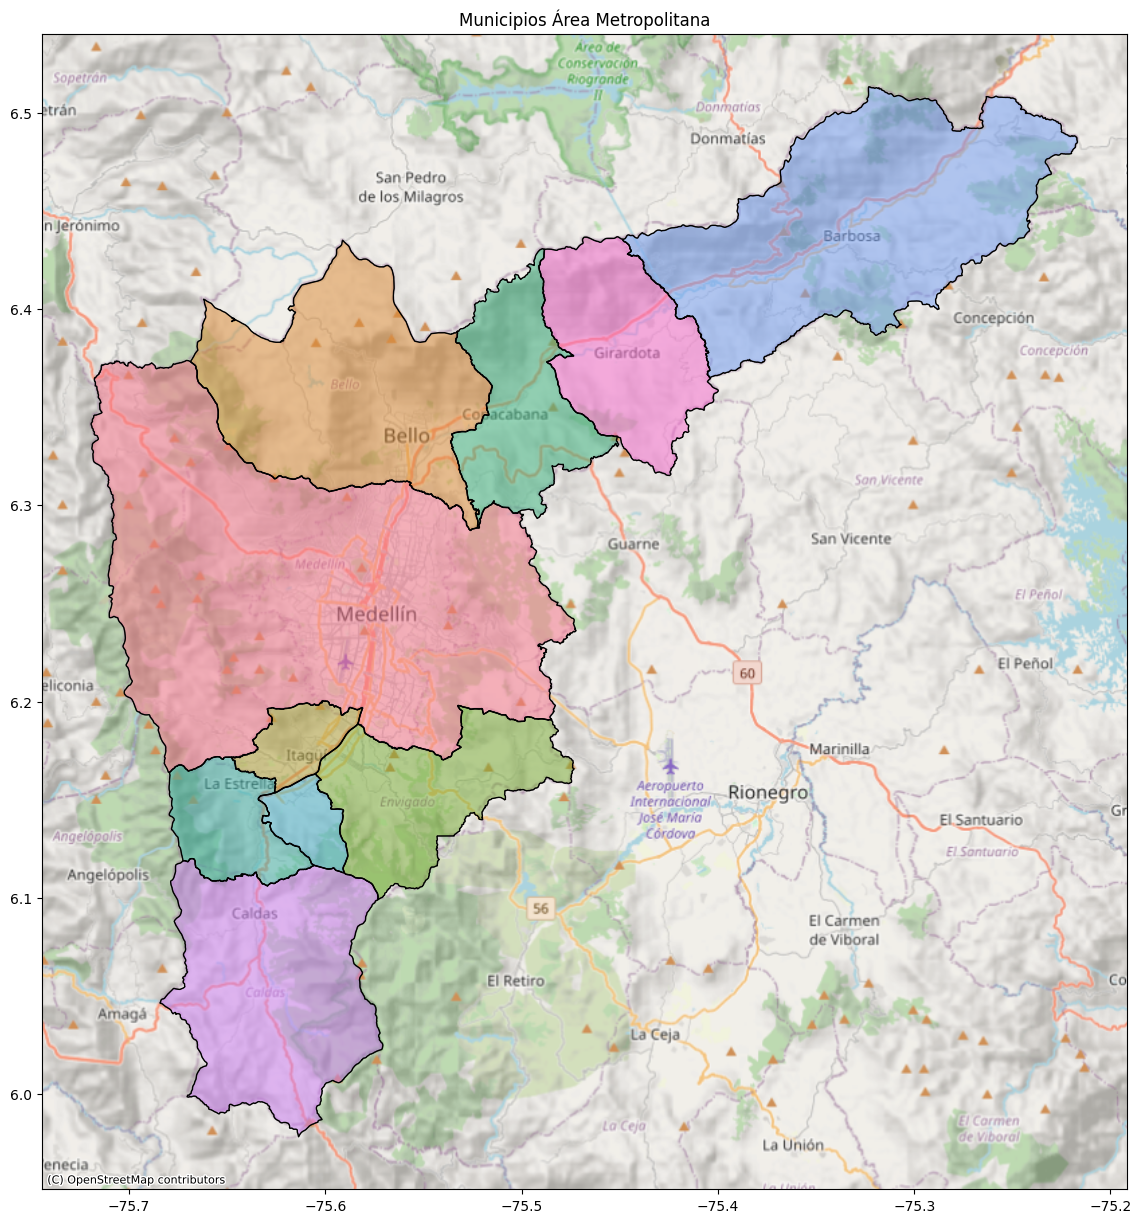

In [12]:
#Implementando la clase Municipios que contiene el Geojson de los municipios de Colombia, se filtran las ciudades 
#especificadas junto con el respectivo departamento al que pertenecen y finalmente ser presentado en mapa geográfico
ciudades = ['MEDELLÍN', 'BELLO', 'ITAGÜÍ', 'ENVIGADO', 'COPACABANA', 'LA ESTRELLA', 'SABANETA', 'BARBOSA', 'CALDAS', 'GIRARDOTA']
departamento = 'ANTIOQUIA'
titulo = 'Municipios Área Metropolitana'
area_metropolitana = Municipios(ciudades, departamento, titulo)
area_metropolitana.plot_municipio_area()

Ya definidas las ciudades a buscar en el campo desciption, se establece el listado requerido con cambio de carácteres necesarios y una función que realice la minería de texto sobre las palabras clave deseadas

In [13]:
#Ciudades del área metropolitada y posible variación de carácteres:
cities = ['Medellín', 'Medellin', 'MEDELLÍN', 'MEDELLIN', 'ITAGUI', 'ITAGUÍ', 'ITAGÜI', "ITAGÜÍ", 'Itagüí',
                 'Itagüi', 'Itagui', 'Itaguí', 'Sabaneta', 'Bello',
                   'Envigado', 'Copacabana', 'Girardota', 'La Estrella', 'Barbosa', 'Caldas']

#Definir función de extreacción de texto requerido basado en palabras clave
def search_cities(descrip):
    if pd.isna(descrip):
        return None
    for cits in cities:
        if re.search(r'\b' + re.escape(cits) + r'\b', str(descrip), flags=re.IGNORECASE):
            return cits
    return None

# Crear nueva columnas y aplicar la función en la respectiva columna 
df_rooms['city'] = df_rooms['description'].apply(search_cities)

#Normalizar resultados
df_rooms['city'] = df_rooms['city'].replace({'Medellin': 'Medellín',
                                                    'MEDELLÍN' : 'Medellín',
                                                    'MEDELLIN': 'Medellín',
                                                    'ITAGUI': 'Itagüí',
                                                    'ITAGUÍ': 'Itagüí',
                                                    'ITAGÜI': 'Itagüí',
                                                    "ITAGÜÍ": 'Itagüí',
                                                    'Itagüi': 'Itagüí',
                                                    'Itagui': 'Itagüí'})

#Aplicar uppercase para mantener un formato unificado en Mayúsculas
df_rooms['city'] = df_rooms['city'].str.upper()

#Observar información agregada
df_rooms.info()
df_rooms.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8192 entries, 0 to 8789
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   id                 8192 non-null   int64    
 1   title              8192 non-null   object   
 2   price              8192 non-null   float64  
 3   description        8192 non-null   object   
 4   long               8192 non-null   float64  
 5   latitude           8192 non-null   float64  
 6   review_airbnb      8192 non-null   float64  
 7   calification_rate  6031 non-null   float64  
 8   created_at         7230 non-null   period[M]
 9   verified           7099 non-null   object   
 10  host_review        6869 non-null   float64  
 11  cameras_on_site    8192 non-null   object   
 12  rooms              8192 non-null   float64  
 13  year               7230 non-null   float64  
 14  city               7830 non-null   object   
dtypes: float64(8), int64(1), object(5), period[

id                                              title  \
0  1011761919469637760                    Hermoso apartamento las  palmas   
1   957959124861517056                        PVT APT  3BD  - Lleras Park   
2   705259118691125248  Amplia y acogedora casa de habitación privada ...   
3              7840662               POBLADO NEAR PARQUE LLERAS APARTMENT   
4   705231926741978496         Dormitorio privado completamente amueblado   

      price                                    description       long  \
0  640000.0  Vivienda rentada entero en Medellín, Colombia -75.557983   
1  791679.0  Vivienda rentada entero en Medellín, Colombia -75.569918   
2  676886.0               Habitación en Medellín, Colombia -75.566890   
3  712512.0  Vivienda rentada entero en Medellín, Colombia -75.564820   
4  676886.0               Habitación en Medellín, Colombia -75.565954   

   latitude  review_airbnb  calification_rate created_at verified  \
0  6.215317            0.0                NaN    2023-08     True   
1  6.210337            0.0                NaN    2023-08     True   
2  6.207200            0.0                NaN    2022-02      NaN   
3  6.207240           65.0               4.86    2015-08      NaN   
4  6.208037            0.0                NaN    2022-02      NaN   

   host_review cameras_on_site  rooms    year      city  
0          NaN            True    2.0  2023.0  MEDELLÍN  
1          NaN            True    2.0  2023.0  MEDELLÍN  
2          NaN           False    1.0  2022.0  MEDELLÍN  
3         65.0           False    3.0  2015.0  MEDELLÍN  
4          NaN           False    1.0  2022.0  MEDELLÍN

La transformación previa presenta algunos nulos sobre la nueva columna creada, no obstante se debe a que en esta descripción pueden presentarse ubicaciones que quedan fuera de las ciudades mencionadas que no están tan lejos de las mismas. Sin embargo, dado que es una baja cantidad de datos vacíos se puede garantizar calidad sobre los mismos, así como una tarea bien hecha sobre la plataforma para ser transparentes con la información suministrada a sus clientes sobre dónde se alojarán al alquilar su hospedaje.

In [14]:
nullcities = df_rooms[df_rooms.city.isnull()]
print(nullcities)

                       id                                            title  \
121    852787994481439488               Casa de verano/piscina/La Estrella   
123    985835334506087680    Cómoda finca en vereda el plan de Santa Elena   
128   1039976229167149824                             Finca en la Estrella   
135    639380672472207872               Casa de lujo en Manila con jacuzzi   
169    725270068737767168    Be Mate Medellin Grand suite con terraza wifi   
...                   ...                                              ...   
8460   709546451029115893  Hermosa Casa De Campo Villa Sofia Cerca al Arví   
8464  1023915603584363146                     Mágico glamping en San Felix   
8469   861560677516284061              Buho Cabaña Familiar en Santa Elena   
8478             52324138          El Deseo de San Jerónimo. Jacuzzi-Turco   
8723             22743519      Auténtica Casa Colonial con más de 100 años   

          price                                        descript

Al observar detenidamente estos datos no clasificados en los municipios escogidos, se puede ver que en su mayoría corresponden a municipios cercanos del Área Metropolitana en cuestión, también zonas rurales aledañas a esta enter otras ubicaciones. Presentando así también una variedad de entorno disponible para hospedajes cortos en la búsqueda establecida.

In [15]:
df_rooms1 = df_rooms[df_rooms['long']>0]
df_rooms1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   id                 0 non-null      int64    
 1   title              0 non-null      object   
 2   price              0 non-null      float64  
 3   description        0 non-null      object   
 4   long               0 non-null      float64  
 5   latitude           0 non-null      float64  
 6   review_airbnb      0 non-null      float64  
 7   calification_rate  0 non-null      float64  
 8   created_at         0 non-null      period[M]
 9   verified           0 non-null      object   
 10  host_review        0 non-null      float64  
 11  cameras_on_site    0 non-null      object   
 12  rooms              0 non-null      float64  
 13  year               0 non-null      float64  
 14  city               0 non-null      object   
dtypes: float64(8), int64(1), object(5), period[M](1)
memory u

## **Análisis de datos**

Una vez realizado los tratamientos previos es posible continuar con la fase de análisi sobre la data.

Como se puede observar, el principal parámetro por el cuál va a estar guiado el análisis será con base a la cantidad de oferta recolectada (alojamientos) y el precio de los mismoos, por lo tanto para simplificar un poco el proceso sobre éste conteo en la agrupación con los demás campos, se creará una función recursiva que se encargue de este proceso.

In [16]:
#Función de conteo de datos y agrupación por columna requerida

def id_por_grupo(dt, columna_gp):
    # Agrupar columna deseada
    grupo_id = dt.groupby(columna_gp).agg({'id': 'count'}).reset_index()
    
    # Verificar si columna_gp es una lista
    if isinstance(columna_gp, list):
        # Si es una lista de una sola columna, asignamos nombres de columnas como lo hacíamos antes
        if len(columna_gp) > 1:
            #grupo_id.columns = [columna_gp[0], "Cantidad Alojamientos"]
        #else:
            # Si es una lista de múltiples columnas, ajustamos los nombres de las columnas
            new_columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grupo_id.columns.values]
            grupo_id.columns = new_columns
            grupo_id.columns = list(grupo_id.columns[:-1]) + ["Cantidad Alojamientos"]
    else:
        # Si no es una lista, asignamos los nombres de las columnas con el mismo número de elementos
        grupo_id.columns = [columna_gp, "Cantidad Alojamientos"]

    return grupo_id



#Función de agrupar por precion
def grupo_por_precios(dt, columna_gpr):
    # Agrupar por columna deseada y calcular múltiples medidas
    grupo_price = dt.groupby(columna_gpr).agg({'price': ['mean', 'median', 'min', 'max']}).reset_index()
    # Renombrar las columnas resultantes
    grupo_price.columns = [columna_gpr, "Precio Promedio", "Precio Mediano", "Precio Mínimo", "Precio Máximo"]
        
    return grupo_price

#Función para formatear precios
def formatear_precios(dataframe):
    # Crear una copia del dataframe para evitar modificar el original
    df = dataframe.copy()
    
    # Formatear los precios como cadenas con formato de moneda
    for col in ["Precio Promedio", "Precio Mediano", "Precio Mínimo", "Precio Máximo"]:
        df[col] = df[col].map("${:,.2f}".format)
    
    return df

El aspecto de ciudad se hace importante de analizar y contemplar, puesto que apesar de haber enfocado esfuerzos de buscar en la plataforma exclusivamente en Medellín, al parecer la forma en que los anfritiones ingresan la información o incluso la manera en que la misma por medio de ubicación o por la zona metropolitana clasifica bajo qué ciudad encontrar los resultados, genera que hayan resultados filtrados de las ciudades o corregimientos vecino (este es el caso de las ciudades no clasificadas con la transfromación anterior)

Alojamientos disponibles por ciudad:
          city  Cantidad Alojamientos  %Contribución
8     MEDELLÍN                   6411          78.26
4     ENVIGADO                    577           7.04
9     SABANETA                    390           4.76
1        BELLO                    183           2.23
6       ITAGÜÍ                    162           1.98
3   COPACABANA                     48           0.59
7  LA ESTRELLA                     36           0.44
5    GIRARDOTA                     16           0.20
2       CALDAS                      6           0.07
0      BARBOSA                      1           0.01


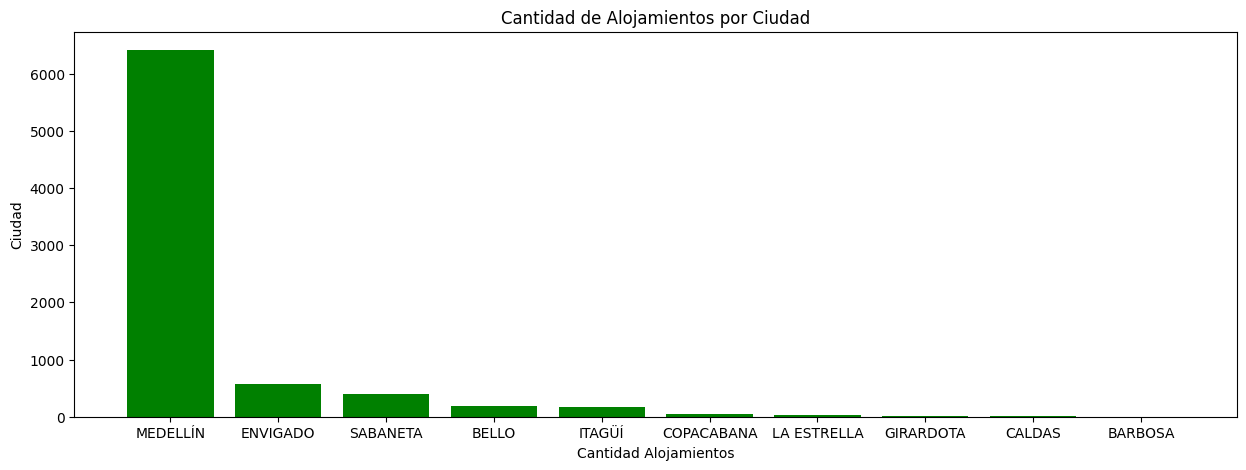

In [17]:
#Calcular la cantidad de alojaientos disponible por ciudad conocida
aloj_por_ciudad = id_por_grupo(df_rooms, 'city')
aloj_por_ciudad['%Contribución'] = ((aloj_por_ciudad['Cantidad Alojamientos']/alojamientos)*100).round(2) #Determinar la proporción por ciudad sobre el total
aloj_por_ciudad = aloj_por_ciudad.sort_values(by = 'Cantidad Alojamientos', ascending= False)
print('Alojamientos disponibles por ciudad:')
print(aloj_por_ciudad)

#Gráfica
plt.figure(figsize=(15, 5))
plt.bar(aloj_por_ciudad['city'], aloj_por_ciudad['Cantidad Alojamientos'], color = 'green')
plt.xlabel('Cantidad Alojamientos')
plt.ylabel('Ciudad')
plt.title('Cantidad de Alojamientos por Ciudad')
plt.show()


Si bien la previa información es útil, dado que casi el 80% de la distribución de los datos está concentrada en la capital del departamento de Antioquia, sin contar el Área Metropolita. Se procede a filtrar estos y realizar análisis más profundos en Medellín. No obstante, se continuará analizando un poco más sobre el Área Metropolitana completa.

In [18]:
#df_medellin = df_rooms[df_rooms['city'] == 'MEDELLÍN']
#df_medellin.to_csv('Data_Medellin.csv', index = False)
#df_medellin.info()

Como se aprecia, se cuenta que la mayor cantidad de alojamientos en efecto se encuentra sobre el área urbana y/o área delimitada de la ciudad de Medellín, contando el 78.26% del total.

La distribución geográfica de estos alojamientos se ve de la siguiente manera:

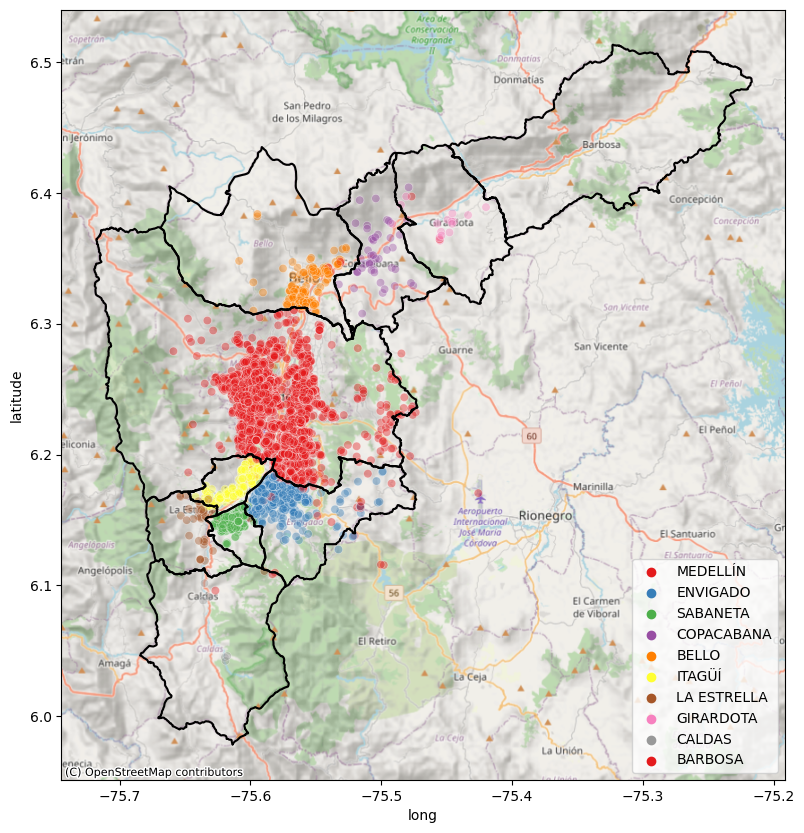

In [19]:
df_rooms = df_rooms[df_rooms['long']<0]
geomap = df_rooms.dropna(subset = ['latitude', 'long'])
geomap = gpd.GeoDataFrame(geomap, geometry=gpd.points_from_xy(geomap['long'], geomap['latitude']))
geomap = geomap.set_crs(epsg=4326)
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar el croquis
area_metropolitana.filter_croquis(ax=ax)

# Graficar los puntos
sns.scatterplot(data=geomap, x='long', y='latitude', hue='city', palette='Set1', alpha=0.4, ax=ax)

# Añadir mapa base
ctx.add_basemap(ax, crs=geomap.crs.to_string(), source=ctx.providers.OpenStreetMap.CH)

# Mostrar la gráfica
plt.legend(loc='lower right') 
plt.show()

Viéndolo por año de creación

In [20]:
#Calcular alojamientos donde se conozca la fecha de creación
df_rooms = df_rooms[df_rooms['created_at'].notnull()]
aloj_por_año_creacion = id_por_grupo(df_rooms, 'year')
aloj_por_año_creacion['Variación Anual'] = (aloj_por_año_creacion['Cantidad Alojamientos'].pct_change()*100).round(2)
or_aloj_por_año_creación = aloj_por_año_creacion.sort_values(by = 'year')
print(or_aloj_por_año_creación)

      year  Cantidad Alojamientos  Variación Anual
0   2010.0                      8              NaN
1   2011.0                     57           612.50
2   2012.0                     58             1.75
3   2013.0                    112            93.10
4   2014.0                    240           114.29
5   2015.0                    473            97.08
6   2016.0                    629            32.98
7   2017.0                    636             1.11
8   2018.0                    662             4.09
9   2019.0                    768            16.01
10  2020.0                    462           -39.84
11  2021.0                    791            71.21
12  2022.0                    959            21.24
13  2023.0                   1326            38.27
14  2024.0                     49           -96.30


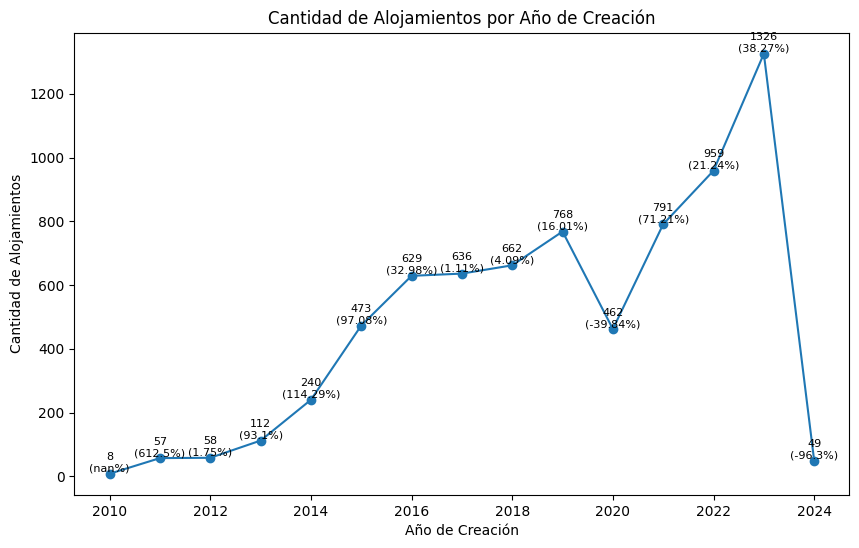

In [21]:
# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(aloj_por_año_creacion['year'], aloj_por_año_creacion['Cantidad Alojamientos'], marker='o', linestyle='-')


# Agregar etiquetas de datos en cada punto
for x, y, va in zip(aloj_por_año_creacion['year'], aloj_por_año_creacion['Cantidad Alojamientos'], aloj_por_año_creacion['Variación Anual']):
    plt.text(x, y, f'{y}\n({va}%)', ha='center', va='bottom', fontsize = 8)

# Etiquetas y título
plt.xlabel('Año de Creación')
plt.ylabel('Cantidad de Alojamientos')
plt.title('Cantidad de Alojamientos por Año de Creación')

# Mostrar el gráfico
plt.show()

In [22]:
#Calcular alojamientos por ciudad y año de creación
aloj_por_año_y_ciudad_creacion = id_por_grupo(df_rooms, ['year', 'city'])
aloj_por_año_y_ciudad_creacion['Variación Anual'] = (aloj_por_año_y_ciudad_creacion.groupby('city')['Cantidad Alojamientos'].pct_change()*100).round(2)
# Ordenar el DataFrame por 'year' y 'city'
aloj_por_año_y_ciudad_creacion = aloj_por_año_y_ciudad_creacion.sort_values(by=['city', 'year'])
print(aloj_por_año_y_ciudad_creacion.to_string(index=False))

  year        city  Cantidad Alojamientos  Variación Anual
2022.0     BARBOSA                      1              NaN
2012.0       BELLO                      2              NaN
2014.0       BELLO                      1           -50.00
2015.0       BELLO                      4           300.00
2016.0       BELLO                     11           175.00
2017.0       BELLO                     15            36.36
2018.0       BELLO                     10           -33.33
2019.0       BELLO                     19            90.00
2020.0       BELLO                     15           -21.05
2021.0       BELLO                     23            53.33
2022.0       BELLO                     23             0.00
2023.0       BELLO                     50           117.39
2024.0       BELLO                      3           -94.00
2018.0      CALDAS                      1              NaN
2019.0      CALDAS                      1             0.00
2022.0      CALDAS                      4           300.

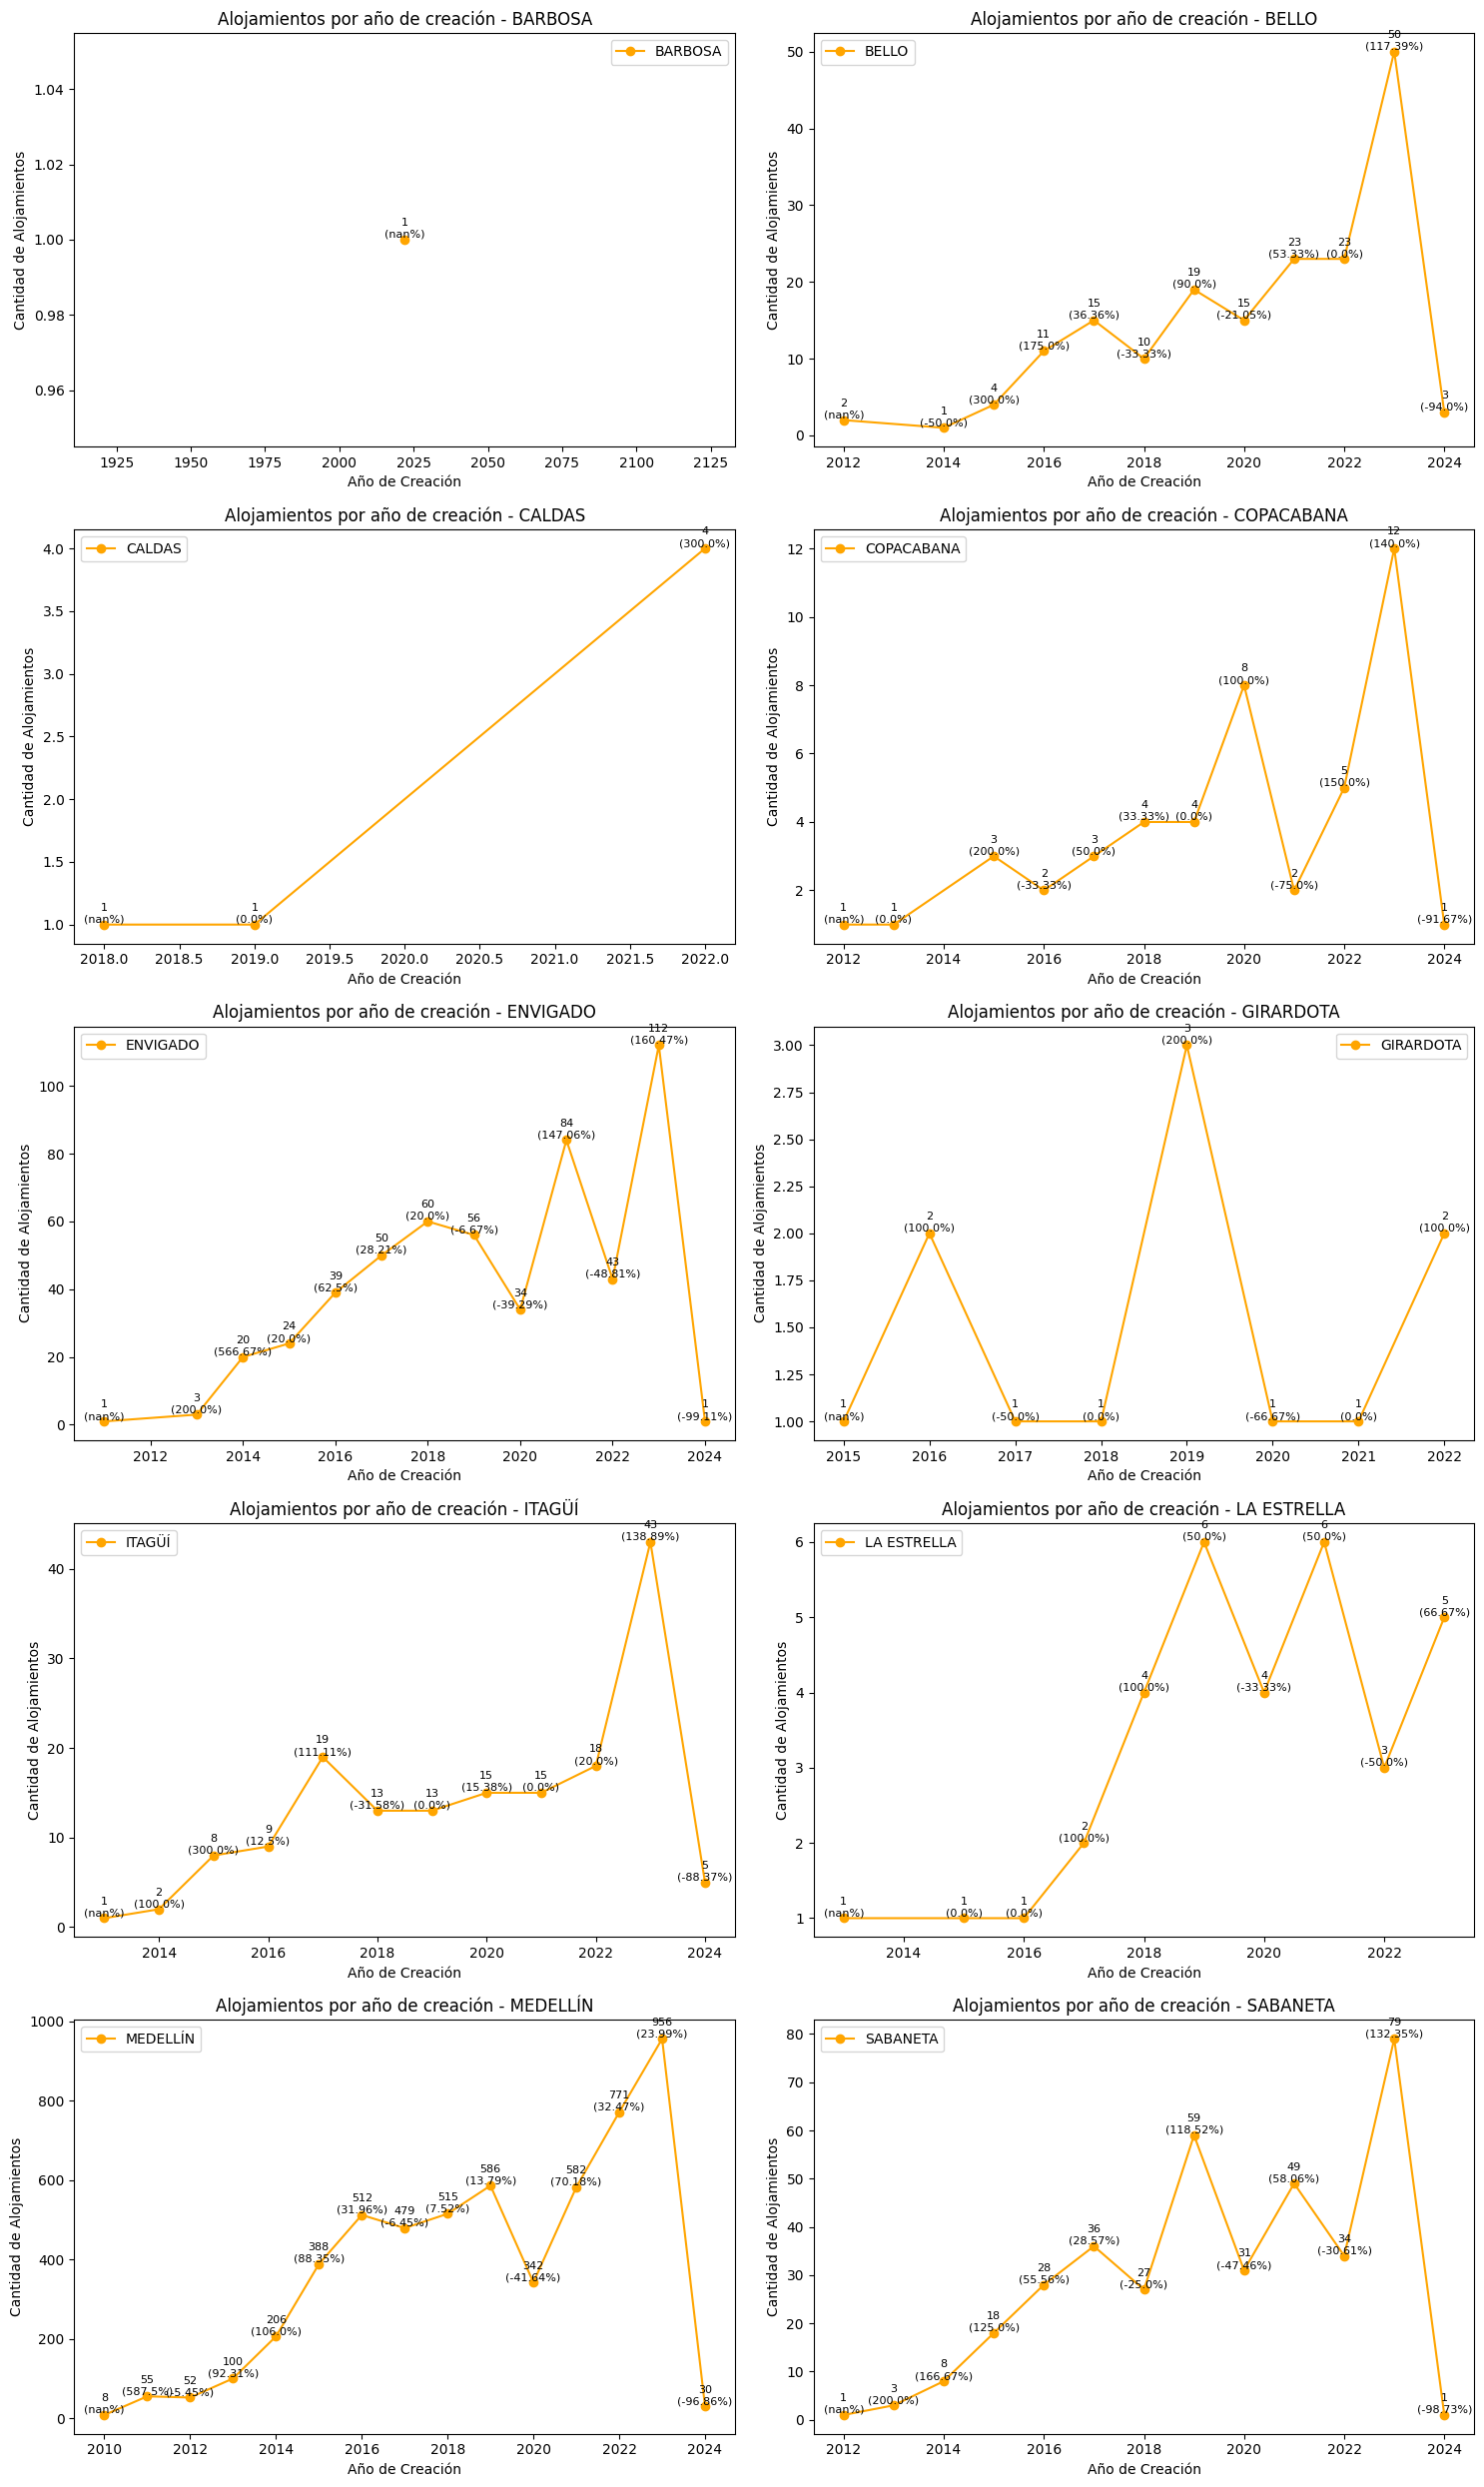

In [23]:
# Obtener la lista de ciudades únicas
ciudades = aloj_por_año_y_ciudad_creacion['city'].unique()

# Calcular el número de filas necesario para el diseño de subplots
num_filas = int(np.ceil(len(ciudades) / 2))

# Crear la figura y los subplots
fig, axs = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
axs = axs.flatten()  # Convertir la matriz de subplots en una lista plana

# Iterar sobre cada ciudad y trazar los datos correspondientes
for i, ciudad in enumerate(ciudades):
    datos_ciudad = aloj_por_año_y_ciudad_creacion[aloj_por_año_y_ciudad_creacion['city'] == ciudad]
    ax = axs[i]  # Seleccionar el subplot actual
    
    # Graficar los datos de la ciudad actual
    ax.plot(datos_ciudad['year'], datos_ciudad['Cantidad Alojamientos'], marker='o', linestyle='-', label=ciudad, color = 'orange')
    
    # Agregar etiquetas de datos en cada punto
    for x, y in zip(datos_ciudad['year'], datos_ciudad['Cantidad Alojamientos']):
        va = datos_ciudad.loc[datos_ciudad['year'] == x, 'Variación Anual'].iloc[0]
        ax.text(x, y, f'{y}\n({va}%)', ha='center', va='bottom', fontsize=8)  # Ajustar el tamaño de fuente aquí

    # Agregar etiquetas y título al subplot
    ax.set_xlabel('Año de Creación')
    ax.set_ylabel('Cantidad de Alojamientos')
    ax.set_title(f'Alojamientos por año de creación - {ciudad}')
    ax.legend()

# Ajustar el diseño de los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()


In [26]:
# Función para generar colores aleatorios evitando el verde
def generate_random_color():
    while True:
        color = np.random.rand(3,)  # Generar un color aleatorio RGB
        # Verificar si el color no es demasiado "verde"
        if color[1] < 0.5:  # Si el valor verde es menor a 0.5, aceptamos el color
            return color

# Crear una lista de años únicos y ordenarlos
years = sorted(df_rooms['year'].unique())

# Calcular el número de filas y columnas para los subplots
num_cols = 3  # Número deseado de años por fila
num_rows = (len(years) + num_cols - 1) // num_cols  # Redondeo hacia arriba para asegurar suficientes filas

# Crear subplots basados en el número de filas y columnas calculado
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Lista para almacenar las leyendas de cada subplot
all_labels = set()

# Diccionario para almacenar los colores de las comunas
ciudads_colors = {}

# Iterar sobre los años únicos y crear un subplot para cada año
for i, year in enumerate(years):
    # Calcular las coordenadas del subplot actual
    row = i // num_cols
    col = i % num_cols
    
    # Filtrar datos para el año actual
    geomap1 = df_rooms[df_rooms['year'] == year]
    geomap1 = geomap1.dropna(subset=['latitude', 'long'])
    geomap1 = gpd.GeoDataFrame(geomap1, geometry=gpd.points_from_xy(geomap1['long'], geomap1['latitude']))
    geomap1 = geomap1.set_crs(epsg=4326)
    
    # Obtener las comunas presentes en el año actual
    current_ciudadss = geomap1['city'].unique()
    
    # Asignar colores a las comunas si aún no tienen uno asignado
    for ciudads in current_ciudadss:
        if ciudads not in ciudads_colors:
            ciudads_colors[ciudads] = generate_random_color()  # Generar un color aleatorio evitando el verde
    
    # Graficar los puntos en el subplot actual
    for ciudads in current_ciudadss:
        ciudads_data = geomap1[geomap1['city'] == ciudads]
        axs[row, col].scatter(ciudads_data['long'], ciudads_data['latitude'], label=ciudads, color=ciudads_colors[ciudads], alpha=0.4)
        all_labels.add(ciudads)  # Agregar el nombre de la comuna a las leyendas
    
    # Configuraciones adicionales para el subplot actual
    axs[row, col].set_title(f'Año de Creación {year}')
    axs[row, col].set_xlabel('Longitud')
    axs[row, col].set_ylabel('Latitud')
    area_metropolitana.filter_croquis(ax=axs[row, col])

# Crear una sola leyenda para todos los subplots
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ciudads_colors[ciudads], markersize=10, label=ciudads) for ciudads in all_labels]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.05, 0.1))

# Agregar mapa base a todos los subplots
for ax in axs.flat:
    ctx.add_basemap(ax, crs=geomap.crs.to_string(), source=ctx.providers.OpenStreetMap.CH)

# Ajustar el espacio entre subplots y mostrar los subplots
plt.tight_layout()
plt.show()


Comportamiento precios (en COP) por ciudad:
          city Precio Promedio Precio Mediano  Precio Mínimo   Precio Máximo
5    GIRARDOTA   $1,915,644.67  $1,710,714.50  $1,091,370.00   $3,218,177.00
2       CALDAS   $1,800,530.83    $179,092.50     $63,000.00   $9,500,000.00
3   COPACABANA   $1,349,726.50    $698,345.00     $71,251.00  $19,791,986.00
4     ENVIGADO     $538,129.46    $181,000.00     $36,000.00   $8,500,000.00
8     MEDELLÍN     $442,594.06    $190,000.00     $32,000.00  $23,623,715.00
7  LA ESTRELLA     $416,242.55    $156,000.00     $56,000.00   $2,000,000.00
0      BARBOSA     $414,286.00    $414,286.00    $414,286.00     $414,286.00
9     SABANETA     $206,938.02    $178,590.50     $42,537.00   $3,040,000.00
1        BELLO     $163,142.81    $147,357.00     $39,912.00   $1,750,000.00
6       ITAGÜÍ     $142,983.38    $120,000.00     $39,584.00   $1,500,000.00


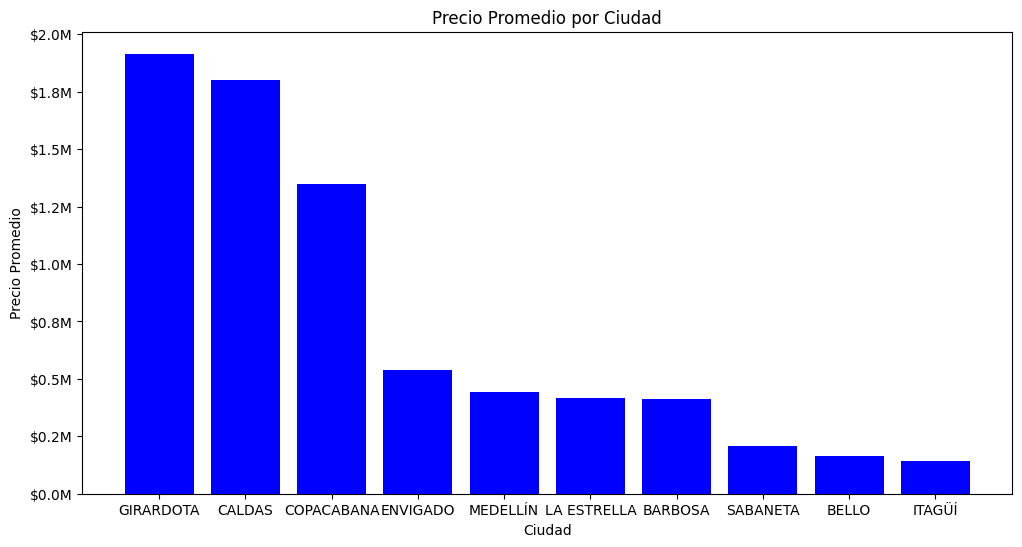

In [ ]:
precio_por_ciudad = grupo_por_precios(df_rooms, 'city')
precio_por_ciudad = precio_por_ciudad.sort_values(by= 'Precio Promedio', ascending= False)
precio_por_ciudad_or = formatear_precios(precio_por_ciudad)
print('Comportamiento precios (en COP) por ciudad:')
print(precio_por_ciudad_or)

plt.figure(figsize=(12, 6))
plt.bar(precio_por_ciudad_or['city'], precio_por_ciudad['Precio Promedio'], color = 'blue')
plt.title('Precio Promedio por Ciudad')
plt.ylabel('Precio Promedio')
plt.xlabel('Ciudad')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:,.1f}M'.format(x*1e-6)))
plt.show()

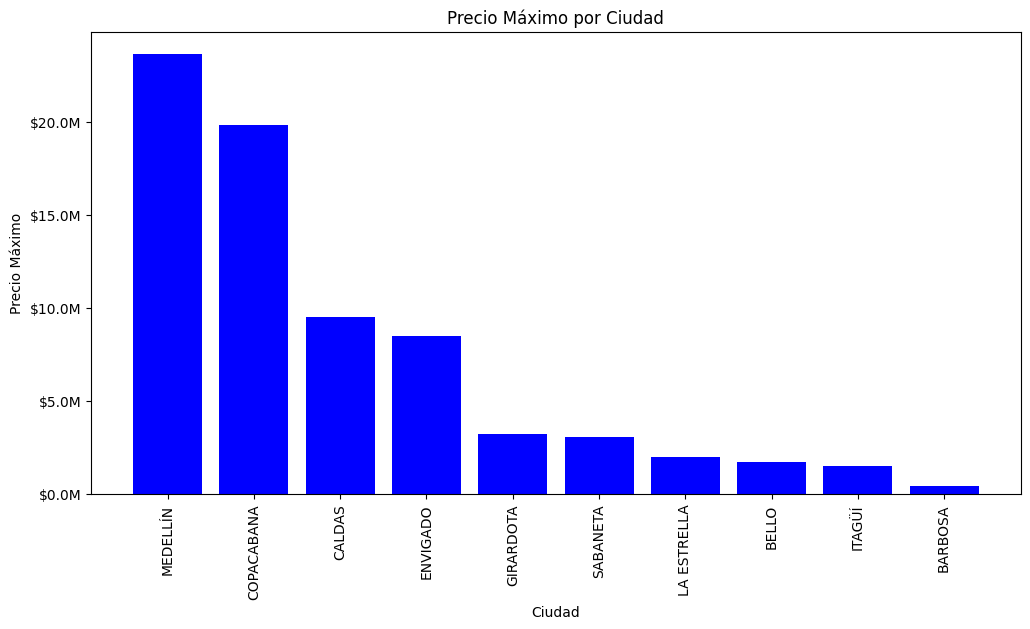

In [ ]:
precio_por_ciudad = precio_por_ciudad.sort_values(by= 'Precio Máximo', ascending= False)
precio_por_ciudad_or = formatear_precios(precio_por_ciudad)
plt.figure(figsize=(12, 6))
plt.bar(precio_por_ciudad_or['city'], precio_por_ciudad['Precio Máximo'], color = 'blue')
plt.xticks(rotation=90)
plt.title('Precio Máximo por Ciudad')
plt.ylabel('Precio Máximo')
plt.xlabel('Ciudad')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:,.1f}M'.format(x*1e-6)))
plt.show()

In [ ]:
precio_por_ciudad = precio_por_ciudad.sort_values(by= 'Precio Mínimo', ascending= False)
precio_por_ciudad_or = formatear_precios(precio_por_ciudad)
plt.figure(figsize=(12, 6))
plt.bar(precio_por_ciudad_or['city'], precio_por_ciudad['Precio Mínimo'], color = 'blue')
plt.xticks(rotation=90)
plt.title('Precio Mínimo por Ciudad')
plt.ylabel('Precio Mínimo')
plt.xlabel('Ciudad')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:,.1f}M'.format(x*1e-6)))
plt.show()

In [ ]:
# Obtener la lista de ciudades únicas
ciudades_unicas = df_rooms['city'].unique()

# Crear una lista para almacenar los DataFrames de precio máximo por ciudad
precio_maximo_por_ciudad = []

# Iterar sobre cada ciudad única
for ciudad in ciudades_unicas:
    # Filtrar los datos para la ciudad actual
    datos_ciudad = df_rooms[df_rooms['city'] == ciudad]
    
    # Encontrar el precio máximo para la ciudad actual
    precio_maximo = datos_ciudad['price'].max()
    
    # Filtrar los datos para obtener la información correspondiente al precio máximo
    datos_precio_maximo = datos_ciudad[datos_ciudad['price'] == precio_maximo]
    
    # Agregar el DataFrame al lista
    precio_maximo_por_ciudad.append(datos_precio_maximo)

# Concatenar los DataFrames en uno solo
info_precio_maximo_por_ciudad = pd.concat(precio_maximo_por_ciudad)

# Restablecer el índice del DataFrame resultante
info_precio_maximo_por_ciudad.reset_index(drop=True, inplace=True)

# Mostrar la información de precio máximo por ciudad
info_precio_maximo_por_ciudad.head(len(info_precio_maximo_por_ciudad))


id                                              title  \
0    932584410029863680        DUBAI in Parque Lleras 3 Heated Pools 23 BR   
1   1065205496722931584                         Hermosa Cabaña en Medellin   
2    960330097567234560                   Hermosa casa de lujo en sabaneta   
3    645902416482793216                    Hermoso apartamento con terraza   
4    876746609973526400                              Medellín From The Sky   
5              18749275                Finca  Antioqueña cerca a Medellín!   
6    831140584788039808                   El hotel de las fiestas Privadas   
7    831163167527195392                    Mansiones para fiestas medellin   
8   1016716463106117760             Wildlife Ecological Center l 5R l Pool   
9    805326144041159680                            Casa moderna y elegante   
10   781884402370765056  Casa finca Paraíso de piedra, en Barbosa Antio...   

         price                                      description       long  \
0   23623715.0         Alojamiento entero en Medellín, Colombia -75.567339   
1    8500000.0              Cabaña entero en Envigado, Colombia -75.531476   
2    3040000.0         Alojamiento entero en Sabaneta, Colombia -75.604773   
3   19791986.0  Vivienda rentada entero en Copacabana, Colombia -75.512177   
4    1750000.0            Alojamiento entero en Bello, Colombia -75.529610   
5    1500000.0         Casa de campo entero en Itagüi, Colombia -75.633960   
6    2000000.0      Alojamiento entero en La Estrella, Colombia -75.634322   
7    2000000.0      Alojamiento entero en La Estrella, Colombia -75.634322   
8    3218177.0        Alojamiento entero en Girardota, Colombia -75.446107   
9    9500000.0           Alojamiento entero en Caldas, Colombia -75.635070   
10    414286.0        Casa de campo entero en Barbosa, Colombia -75.538446   

    latitude  review_airbnb  calification_rate created_at verified  \
0   6.207590            0.0                NaN    2019-06     True   
1   6.165756            0.0                NaN    2023-11     True   
2   6.145435            0.0                NaN    2023-08     True   
3   6.345477            1.0                NaN    2019-05     True   
4   6.357060            5.0               5.00    2023-04     True   
5   6.176130            5.0               5.00    2016-10     True   
6   6.152872            0.0                NaN    2019-05     True   
7   6.152872            0.0                NaN    2019-05     True   
8   6.378169            0.0                NaN    2015-08     True   
9   6.101700            0.0                NaN    2022-06     True   
10  6.339491           19.0               4.84    2022-12     True   

    host_review cameras_on_site  rooms    year         city  
0         175.0            True   23.0  2019.0     MEDELLÍN  
1           NaN           False    5.0  2023.0     ENVIGADO  
2           NaN           False    5.0  2023.0     SABANETA  
3           NaN           False    1.0  2019.0   COPACABANA  
4           5.0            True    4.0  2023.0        BELLO  
5           5.0           False   10.0  2016.0       ITAGÜÍ  
6           NaN            True    3.0  2019.0  LA ESTRELLA  
7           NaN            True    3.0  2019.0  LA ESTRELLA  
8         719.0           False    5.0  2015.0    GIRARDOTA  
9           NaN            True    3.0  2022.0       CALDAS  
10         19.0            True    3.0  2022.0      BARBOSA

In [ ]:
# Crear una lista para almacenar los DataFrames de precio máximo por ciudad
precio_minimo_por_ciudad = []

# Iterar sobre cada ciudad única
for ciudad in ciudades_unicas:
    # Filtrar los datos para la ciudad actual
    datos_ciudad = df_rooms[df_rooms['city'] == ciudad]
    
    # Encontrar el precio máximo para la ciudad actual
    precio_minimo = datos_ciudad['price'].min()
    
    # Filtrar los datos para obtener la información correspondiente al precio máximo
    datos_precio_minimo = datos_ciudad[datos_ciudad['price'] == precio_minimo]
    
    # Agregar el DataFrame al lista
    precio_minimo_por_ciudad.append(datos_precio_minimo)

# Concatenar los DataFrames en uno solo
info_precio_minimo_por_ciudad = pd.concat(precio_minimo_por_ciudad)

# Restablecer el índice del DataFrame resultante
info_precio_minimo_por_ciudad.reset_index(drop=True, inplace=True)

# Mostrar la información de precio máximo por ciudad
info_precio_minimo_por_ciudad.head(len(info_precio_minimo_por_ciudad))

id                                              title  \
0   1022120719042206711                               Habitación agradable   
1    942657337014300207                             En alquiler , envigado   
2    860186001252364494               Habitación privada compartida piso 2   
3    822344299835752829              Piso compartido de habitación privada   
4              18007203  Apartamento acogedor y privado en el campo (RN...   
5    939397759684148908                   Habitación al norte de MEDELLÍN.   
6    844962769628793284                   Habitación Privada - Casa Itagüí   
7              21281194            Tierra Fresca: La Estrella  Bella Vista   
8   1025593493111159808  Hermosa casa de recreo con piscina. FincaGIRAR...   
9    804582327154288955                       Minicasa asequible en Caldas   
10   781884402370765056  Casa finca Paraíso de piedra, en Barbosa Antio...   

        price                                      description       long  \
0     32000.0                 Habitación en MEDELLÍN, Colombia -75.571126   
1     36000.0                 Habitación en Envigado, Colombia -75.585957   
2     42537.0                 Habitación en Sabaneta, Colombia -75.609300   
3     42537.0                 Habitación en Sabaneta, Colombia -75.610060   
4     71251.0  Vivienda rentada entero en Copacabana, Colombia -75.504570   
5     39912.0                    Habitación en Bello, Colombia -75.542629   
6     39584.0                   Habitación en Itagüí, Colombia -75.594915   
7     56000.0              Habitación en La Estrella, Colombia -75.646990   
8   1091370.0        Alojamiento entero en Girardota, Colombia -75.444562   
9     63000.0      Vivienda rentada entero en Caldas, Colombia -75.631318   
10   414286.0        Casa de campo entero en Barbosa, Colombia -75.538446   

    latitude  review_airbnb  calification_rate created_at verified  \
0   6.300860            1.0                NaN    2020-02      NaN   
1   6.160462            0.0                NaN    2023-09      NaN   
2   6.143100            8.0               5.00    2020-02      NaN   
3   6.142206            7.0               4.86    2020-02      NaN   
4   6.366100           36.0               4.81    2015-08     True   
5   6.331343            2.0                NaN    2023-08      NaN   
6   6.191898           14.0               4.93    2023-02      NaN   
7   6.158540            0.0                NaN    2018-02      NaN   
8   6.378042            3.0               5.00    2017-01     True   
9   6.091153           16.0               4.81    2019-11     True   
10  6.339491           19.0               4.84    2022-12     True   

    host_review cameras_on_site  rooms    year         city  
0           NaN           False    1.0  2020.0     MEDELLÍN  
1           NaN           False    1.0  2023.0     ENVIGADO  
2           NaN           False    1.0  2020.0     SABANETA  
3           NaN           False    1.0  2020.0     SABANETA  
4          36.0           False    1.0  2015.0   COPACABANA  
5           NaN           False    1.0  2023.0        BELLO  
6           NaN           False    1.0  2023.0       ITAGÜÍ  
7           NaN           False    2.0  2018.0  LA ESTRELLA  
8          73.0           False    4.0  2017.0    GIRARDOTA  
9          34.0           False    1.0  2019.0       CALDAS  
10         19.0            True    3.0  2022.0      BARBOSA